# Описание проекта  
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  
* Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

 **План работы над проектом**
1. Провести исследовательский анализ набора фотографий.
2. Подготовить данные к обучению.
3. Обучить нейронную сеть и рассчитайте её качество.

# Исследовательский анализ данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50

%matplotlib inline

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.duplicated().sum()

0

В файле `labels.csv` содержится информация о 7591 фотографии, пропусков и дубликатов нет. Выборка для оценки возраста достаточно маленькая, вероятно лучше применить предобученные модели.

In [6]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


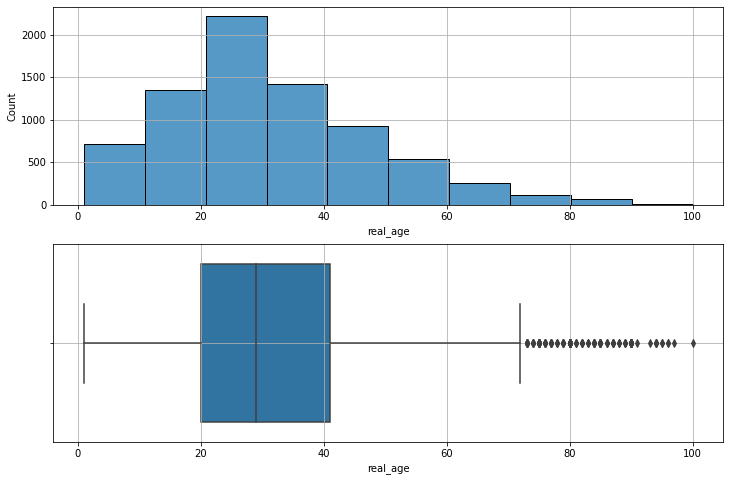

In [7]:
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
sns.histplot(labels['real_age'], bins=10)
plt.grid()
plt.subplot(2,1,2)
sns.boxplot(x=labels['real_age'])
plt.grid()
plt.show();

В датасете представлены все возрастные группы. Явно ошибочных значений нет. Средний возраст составляет примерно 31 год. Наибольшее количество людей принадлежат возрастной категории от 20 до 30 лет. Характер распределения близок к нормальному, при этом имеется скос вправо. По характеру боксплота, наблюдения со значением возраста более 70 лет можно отнести к выбросам, однако, это редкие, а не ошибочные наблюдения и могут также набюдаться в тестовой выборке.

Напечатаем первые 15 фотографий из датасета.

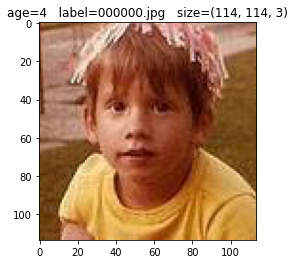

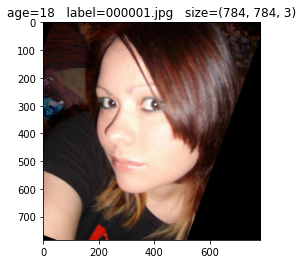

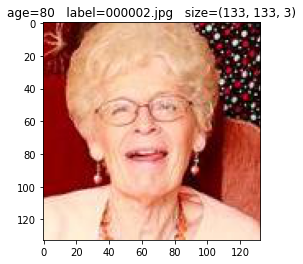

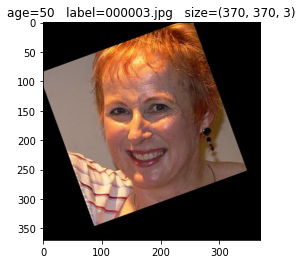

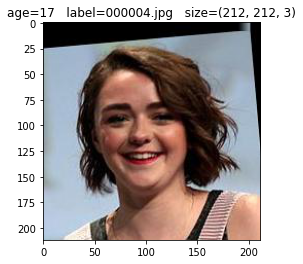

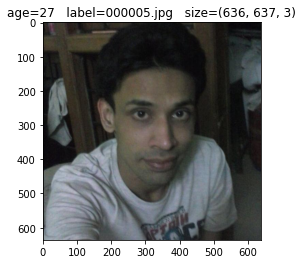

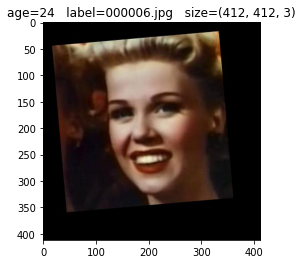

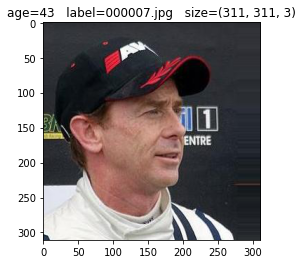

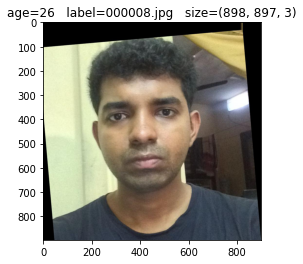

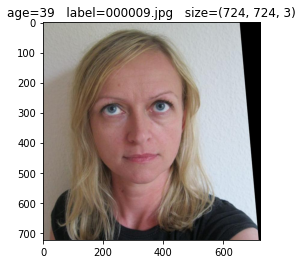

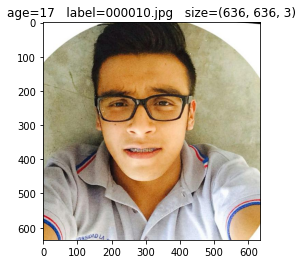

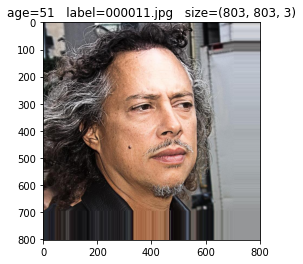

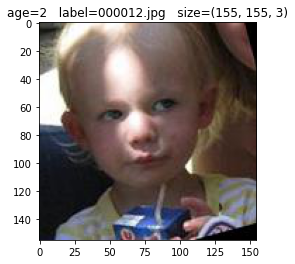

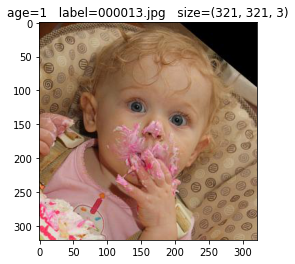

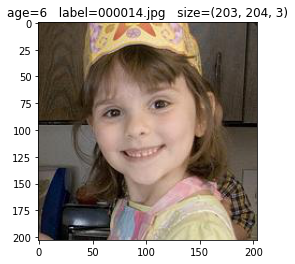

In [8]:
for label in labels.file_name[:15]:
    image = Image.open('/datasets/faces/final_files/'+label)
    array = np.array(image)
    age = int(labels[labels['file_name'] == label].real_age)
    plt.title(f'age={str(age)}   label={label}   size={str(array.shape)}')
    plt.imshow(array)
    plt.show()

В папке лежат изображения разного размера, что потребует перед обучением приведением их к одинаковому размеру. Фотографии цветные, некоторые фотографии имеют небольшой наклон, однако их количество и угол наклона, вероятно, не будет критичным для обучения модели. 

## Обучение моделей

Обучим модели с архитектурой LeNet и ResNet50. Качество модели оценим на отложенной выборке, составляющей 25% от исходного датасета

### Архитектура LeNetm

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential

def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(
                    rescale=1/255,
                    validation_split=0.25)
    train_data = train_datagen.flow_from_dataframe(
    dataframe=labels,
    x_col='file_name',
    y_col='real_age',
    directory=path+'final_files/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=12345) 

    return train_data 


def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(
                    rescale=1/255,
                    validation_split=0.25)
    test_data = test_datagen.flow_from_dataframe(
    dataframe=labels,
    x_col='file_name',
    y_col='real_age',
    directory=path+'final_files/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345) 

    return test_data 


def create_model(input_shape):
    model = Sequential()
    model.add(Conv2D(filters=6, kernel_size=(5, 5), padding='same', activation='relu',
                     input_shape=input_shape))
    model.add(AvgPool2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=16, kernel_size=(5, 5), padding='valid', activation='relu'))
    model.add(AvgPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=10, activation='relu'))
    model.add(Dense(units=1, activation='relu'))

    model.compile(optimizer='adam', loss='mean_squared_error', 
              metrics=['mean_absolute_error']) 
    return model


def train_model(model, train_data, test_data, epochs=20, batch_size=None,
               steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data,
            validation_data=test_data, 
            batch_size=batch_size,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            verbose=2)
 
    return model

if __name__ == "__main__":
    train_data = load_train('/datasets/faces/')
    test_data = load_test('/datasets/faces/')
    model = create_model((224, 224, 3))
    model = train_model(model, train_data, test_data, steps_per_epoch=len(train_data), validation_steps=len(test_data))

Train for 178 steps, validate for 60 steps  
Epoch 1/20  
2022-07-04 13:23:42.588877: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10  
2022-07-04 13:23:42.894609: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7  
178/178 - 39s - loss: 326.5838 - mean_absolute_error: 13.8848 - val_loss: 281.1294 - val_mean_absolute_error: 12.5402  
Epoch 2/20  
178/178 - 37s - loss: 280.1178 - mean_absolute_error: 12.9599 - val_loss: 257.4806 - val_mean_absolute_error: 12.7394  
Epoch 3/20  
178/178 - 37s - loss: 261.2763 - mean_absolute_error: 12.4627 - val_loss: 240.2058 - val_mean_absolute_error: 12.1317  
Epoch 4/20  
178/178 - 37s - loss: 246.9221 - mean_absolute_error: 12.1026 - val_loss: 232.1193 - val_mean_absolute_error: 11.7575  
Epoch 5/20  
178/178 - 37s - loss: 228.3133 - mean_absolute_error: 11.6090 - val_loss: 248.2547 - val_mean_absolute_error: 12.7840  
Epoch 6/20  
178/178 - 37s - loss: 216.1122 - mean_absolute_error: 11.3283 - val_loss: 245.7659 - val_mean_absolute_error: 12.6602  
Epoch 7/20  
178/178 - 38s - loss: 194.1974 - mean_absolute_error: 10.7287 - val_loss: 228.8437 - val_mean_absolute_error: 11.4861  
Epoch 8/20  
178/178 - 38s - loss: 184.2433 - mean_absolute_error: 10.4448 - val_loss: 233.0713 - val_mean_absolute_error: 12.0619  
Epoch 9/20  
178/178 - 38s - loss: 166.3791 - mean_absolute_error: 9.9901 - val_loss: 275.6869 - val_mean_absolute_error: 13.2978  
Epoch 10/20  
178/178 - 37s - loss: 147.7533 - mean_absolute_error: 9.4518 - val_loss: 236.1399 - val_mean_absolute_error: 11.7002  
Epoch 11/20  
178/178 - 37s - loss: 136.1344 - mean_absolute_error: 9.0356 - val_loss: 229.2571 - val_mean_absolute_error: 11.7498  
Epoch 12/20  
178/178 - 38s - loss: 119.1368 - mean_absolute_error: 8.4845 - val_loss: 256.6733 - val_mean_absolute_error: 12.6612  
Epoch 13/20  
178/178 - 37s - loss: 106.5513 - mean_absolute_error: 8.0060 - val_loss: 236.9170 - val_mean_absolute_error: 11.8553  
Epoch 14/20  
178/178 - 37s - loss: 92.8282 - mean_absolute_error: 7.4943 - val_loss: 245.3844 - val_mean_absolute_error: 11.9916  
Epoch 15/20  
178/178 - 37s - loss: 78.9767 - mean_absolute_error: 6.9062 - val_loss: 243.4647 - val_mean_absolute_error: 12.0292  
Epoch 16/20  
178/178 - 37s - loss: 67.9223 - mean_absolute_error: 6.3652 - val_loss: 277.4789 - val_mean_absolute_error: 13.0194  
Epoch 17/20  
178/178 - 37s - loss: 59.4510 - mean_absolute_error: 5.9747 - val_loss: 265.6107 - val_mean_absolute_error: 12.4369  
Epoch 18/20  
178/178 - 37s - loss: 51.5829 - mean_absolute_error: 5.5497 - val_loss: 265.4831 - val_mean_absolute_error: 12.4819  
Epoch 19/20  
178/178 - 38s - loss: 44.0872 - mean_absolute_error: 5.1080 - val_loss: 260.1841 - val_mean_absolute_error: 12.2873  
Epoch 20/20  
178/178 - 37s - loss: 39.3953 - mean_absolute_error: 4.8642 - val_loss: 281.8126 - val_mean_absolute_error: 12.8345  
60/60 - 10s - loss: 281.8126 - mean_absolute_error: 12.8345  
Test MAE: 12.8345

Метрика MAE за 20 эпох достигла значения 4,8 лет на обучающей выборке и 12,8 лет по тестовой выборке, что недостаточно для решения поставленных задач. 

### Архитектура ResNet50

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(
                    horizontal_flip=True,
                    rescale=1/255,
                    validation_split=0.25)
    train_data = train_datagen.flow_from_dataframe(
    dataframe=labels,
    x_col='file_name',
    y_col='real_age',
    directory=path+'final_files/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=12345) 

    return train_data 


def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(
                    rescale=1/255,
                    validation_split=0.25)
    test_data = test_datagen.flow_from_dataframe(
    dataframe=labels,
    x_col='file_name',
    y_col='real_age',
    directory=path+'final_files/',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345) 

    return test_data 


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
 
    model.compile(optimizer=Adam(lr=0.0005), loss='mean_squared_error', 
              metrics=['mean_absolute_error']) 
    return model


def train_model(model, train_data, test_data, epochs=10, batch_size=None,
               steps_per_epoch=None, validation_steps=None):
    
    model.fit(train_data,
            validation_data=test_data, 
            batch_size=batch_size,
            epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            verbose=2)
 
    return model

if __name__ == "__main__":
    train_data = load_train('/datasets/faces/')
    test_data = load_test('/datasets/faces/')
    model = create_model((224, 224, 3))
    model = train_model(model, train_data, test_data, steps_per_epoch=len(train_data), validation_steps=len(test_data))

Train for 178 steps, validate for 60 steps  
Epoch 1/10  
2022-07-05 10:40:36.926542: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10  
2022-07-05 10:40:37.220642: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7  
178/178 - 47s - loss: 200.5473 - mean_absolute_error: 10.4804 - val_loss: 406.0863 - val_mean_absolute_error: 15.1455  
Epoch 2/10  
178/178 - 39s - loss: 108.5945 - mean_absolute_error: 7.8229 - val_loss: 491.4372 - val_mean_absolute_error: 17.0765  
Epoch 3/10  
178/178 - 39s - loss: 85.0601 - mean_absolute_error: 7.0074 - val_loss: 300.6899 - val_mean_absolute_error: 12.8770  
Epoch 4/10  
178/178 - 39s - loss: 68.5006 - mean_absolute_error: 6.2548 - val_loss: 230.4495 - val_mean_absolute_error: 11.1701  
Epoch 5/10  
178/178 - 38s - loss: 56.0976 - mean_absolute_error: 5.6829 - val_loss: 112.9897 - val_mean_absolute_error: 8.1824  
Epoch 6/10  
178/178 - 38s - loss: 50.4744 - mean_absolute_error: 5.4080 - val_loss: 124.5169 - val_mean_absolute_error: 8.5000  
Epoch 7/10  
178/178 - 38s - loss: 38.3962 - mean_absolute_error: 4.7634 - val_loss: 108.0585 - val_mean_absolute_error: 7.9151  
Epoch 8/10  
178/178 - 38s - loss: 34.8684 - mean_absolute_error: 4.5500 - val_loss: 111.7167 - val_mean_absolute_error: 7.5223  
Epoch 9/10  
178/178 - 38s - loss: 29.3641 - mean_absolute_error: 4.1707 - val_loss: 78.6207 - val_mean_absolute_error: 6.6845  
Epoch 10/10  
178/178 - 38s - loss: 24.3483 - mean_absolute_error: 3.8207 - val_loss: 79.1700 - val_mean_absolute_error: 6.7869  
60/60 - 9s - loss: 79.1700 - mean_absolute_error: 6.7869  
Test MAE: 6.7869

MAE модели ResNet50, предобученной на датасете ImageNet на тестовом наборе данных достигла 6.7 лет, что удовлетворяет требованиям по точности прогноза. Таким образом, обученная модель позволяет с достаточно высокой точностью предсказывать возраст покупателей.  
Значения МАЕ 7 лет можно считать хорошим показатем для решения первой задачи - определения возрастной группы покупателя, так как ошибка модели не будет критичной для отнесения к той или иной возрастной группе и вариации покупательских предпочтений. В то же время для решения второй задачи по контролю добросовестности кассиров при продаже алкоголя, вероятно, точность в 7 лет будет недостаточна. Для решения этой задачи нужна высокая точность модели в возрастном промежутке около 18 лет и вероятно потребуется более сложная модель, детальная настройка и более крупный датасет с акцентом на изображения подростков и молодых людей.